# Supplementary Table 1. DROSHA dependency

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-18.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
from Bio import SeqIO
from collections import defaultdict
import pandas as pd
import numpy as np

In [4]:
cols = ['Pri-miRNA', 'DROSHA dependency', 'MirGeneDB']
tbl = pd.DataFrame(columns=cols).set_index('Pri-miRNA')
tbl.head(1)

,DROSHA dependency,MirGeneDB
Pri-miRNA,,


---

In [5]:
def parse_line(row):
    for s in row['attr'].split(';'):
        tag, value = s.split('=')
        row[tag] = value
    return row

In [32]:
# miBRase v21 gff file
gff = 'supplementary/human_mirbase-v21.gff3'
anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                       names=['chr','kind','start','end','strand','attr'])
anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
anntbl.head(3)

,Alias,Derives_from,ID,Name,chr,end,kind,start,strand
0,MI0022705,NaN,MI0022705,hsa-mir-6859-1,chr1,17436,miRNA_primary_transcript,17369,-
1,MIMAT0027618,MI0022705,MIMAT0027618,hsa-miR-6859-5p,chr1,17431,miRNA,17409,-
2,MIMAT0027619,MI0022705,MIMAT0027619,hsa-miR-6859-3p,chr1,17391,miRNA,17369,-


In [33]:
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')
allpris = sorted(annpri.index)
print len(allpris)

1881


In [8]:
# pri-mature matching
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['Name'].tolist()

In [9]:
## DROSHA-independent pri-miRNAs: mirtrons & capped 
# Kim et al. (2017) table s1.
grpexcel = pd.ExcelFile('supplementary/Kim_2017_s1.xlsx')
grptbl = grpexcel.parse('Sheet1', index_col=0)
grptbl.index = [ 'hsa-%s'%i.strip() for i in grptbl.index ]

In [10]:
from collections import Counter
Counter(grptbl['DROSHA dependency'])

Counter({u'Capped miRNA': 11,
         u'DROSHA-dependent': 1624,
         u'Mirtron': 239,
         u'SnoRNA-derived miRNA': 6,
         u'tRNA-related miRNA': 1})

In [11]:
## DROSHA-dependent pri-miRNAs: DROSHA KO-sensitive
# Kim et al. (2016) PNAS
koexcel = pd.ExcelFile('supplementary/Kim_2016_s1.xlsx')
droko = koexcel.parse('DroKO', index_col=0)
drosensi = droko[droko['Group'].apply(lambda x: x in [1,2,4])].index
drosensitive = [ pri for pri in allpris if set.intersection(set(primat[pri]),set(drosensi)) ]
print len(drosensitive)

157


In [12]:
## DROSHA-dependent pri-miRNAs: DROSHA fCLIP-detected
# Kim et al. (2017) Mol. Cell
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
f293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fhela = fclipexcel.parse('HeLa_miRBase', index_col=0)
mirs293t = f293t[(f293t['Group5p']!='Unidentified')&(f293t['Group3p']!='Unidentified')].index
mirshela = fhela[(fhela['Group5p']!='Unidentified')&(fhela['Group3p']!='Unidentified')].index
fclipmirs = [ mir for mir in allpris if mir in mirs293t or mir in mirshela ]
print len(fclipmirs)

281


In [23]:
chiang = 'hsa-mir-122 hsa-mir-137 hsa-mir-138-1 hsa-mir-139 hsa-mir-153-2 hsa-mir-208a \
hsa-mir-193b hsa-mir-216a hsa-mir-217 hsa-mir-223 hsa-mir-224 hsa-mir-375 hsa-mir-1912 \
hsa-mir-338'.split()
print len(chiang), len([m for m in chiang if m in allpris])

14 14


In [25]:
note = defaultdict(list)
for m in drosensitive:
    note[m].append('DROSHA KO')
for m in fclipmirs:
    note[m].append('fCLIP-seq')
for m in chiang:
    note[m].append('ectopic expression')
print len(note)

310


In [26]:
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
%matplotlib inline

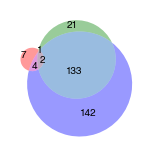

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
data = [ set(chiang), set(drosensitive), set(fclipmirs) ]
out = venn3(subsets=data, set_labels=('','',''), ax=ax)

In [28]:
for p in allpris:
    if grptbl.loc[p,'DROSHA dependency']!='DROSHA-dependent':
        tbl.loc[p,'DROSHA dependency'] = 'DROSHA-independent, %s'%\
        grptbl.loc[p,'DROSHA dependency']
    elif p=='hsa-mir-451a':
        tbl.loc[p,'DROSHA dependency'] = 'DROSHA-dependent'
    elif p in note:
        tbl.loc[p,'DROSHA dependency'] = 'DROSHA-dependent, verified by %s'%', '.join(note[p])
    else:
        tbl.loc[p,'DROSHA dependency'] = 'Not yet determined'

In [34]:
anntbl = anntbl.set_index('ID')

In [35]:
dbv2f = 'supplementary/mirgenedb_v2.gff'
dbv2 = pd.read_table(dbv2f, sep='\t', header=2, usecols=[0,2,3,4,6,8], 
                     names=['chr','type','start','end','strand','info'])
dbv2['db id'] = dbv2['info'].apply(lambda x:x.split(';')[0].split('=')[1]) # Hsa-Let-7-P1_pre
dbv2['db name'] = dbv2['db id'].apply(lambda x:x.split('_')[0]) # Hsa-Let-7-P1
dbv2pre = dbv2[dbv2['type']=='pre_miRNA']
dbv2pre = dbv2pre[dbv2pre['info'].apply(lambda x:x.find('Alias')>=0)]
dbv2pre['mb name'] = dbv2pre['info'].apply(lambda x:x.split(';')[1].split('=')[1])
dbmirs = dbv2pre['mb name'].tolist()
dbmirs = set([ anntbl.loc[i,'Name'] for i in dbmirs if i in anntbl.index ])
print len(dbmirs)
for pri in allpris:
    if pri in dbmirs:
        tbl.loc[pri,'MirGeneDB'] = 'Annotated'

503


In [36]:
tbl.to_csv('resources/210118_s1__DROSHA_dependency.csv')

In [37]:
out = open('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 'wt')
description = 'Supplementary Table 1. DROSHA dependency\n\n\n\n\n'
out.write(description)
for l in open('resources/210118_s1__DROSHA_dependency.csv', 'rt'):
    out.write(l)
out.close()